## CNN en CIFAR-10

En esta sección se entrena y compara el desempeño de tres redes neuronales convolucionales aplicadas al conjunto de imágenes CIFAR-10:

- **C1 – CNN sencilla (baseline)**: arquitectura básica con una capa convolucional y MaxPooling.
- **C2 – CNN mejorada**: mayor profundidad de la red, incorporación de Batch Normalization y Dropout.
- **C3 – CNN optimizada con Data Augmentation**: se añaden transformaciones aleatorias para mejorar la generalización.

El objetivo es analizar cómo el aumento de la complejidad del modelo y las técnicas de regularización impactan en el rendimiento.  
Se evalúa cada arquitectura mediante **accuracy**, **F1-score**, matriz de confusión y análisis de errores visuales sobre el conjunto de prueba.


## Importación de librerías y configuración inicial

En esta sección se cargan todas las librerías necesarias para el proyecto, tales como:
- **TensorFlow y Keras** para definir y entrenar las redes CNN.
- **NumPy** para manejo de arreglos.
- **Matplotlib y Seaborn** para visualización.
- **Scikit-learn** para evaluación de métricas y manipulación de datasets.

Además, se fija una semilla aleatoria para asegurar **reproducibilidad** de los resultados en los entrenamientos.
También se define el tamaño de lote (**batch size**) que se utilizará en todos los experimentos.


In [10]:
# Imports y configuración

import numpy as np                      # Manejo de arreglos numéricos
import tensorflow as tf                 # Framework principal de deep learning
from tensorflow import keras            # API de alto nivel de TensorFlow
from tensorflow.keras import layers     # Capas para construir las redes
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt         # Gráficas
import seaborn as sns                   # Gráficas 
import pandas as pd                     # Manejo de tablas y CSV
import time                             # Tiempos de entrenamiento

# Semilla fija para que los resultados sean reproducibles
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Tamaño de lote usado en todos los experimentos de la CNN
BATCH_SIZE = 64

# Libro de registro
registro_cnn = []


## Carga y Preprocesamiento de CIFAR-10

Se carga el dataset **CIFAR-10**, formado por imágenes RGB de 32×32 en 10 clases distintas.

- Conversión de pixeles a rango **[0, 1]** para mejorar estabilidad del entrenamiento.
- Aplanado de etiquetas a formato adecuado para `sparse_categorical_crossentropy`.
- Separación del conjunto de entrenamiento en **train y validación (20%)** conservando el balance entre clases.

En esta etapa también se muestran las dimensiones finales de cada partición.


In [11]:
# Carga y preprocesamiento de CIFAR-10

# CIFAR-10: 50 000 imágenes de entrenamiento y 10 000 de prueba (32x32x3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Se normalizan los pixeles de 0–255 a 0–1 para mejorar la estabilidad numérica
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

# Convierte las etiquetas de forma (N,1) a (N,) para usarlas con sparse_categorical_crossentropy
y_train = y_train.reshape(-1)
y_test  = y_test.reshape(-1)

# Se reserva un 20% del conjunto de entrenamiento para validación,
# manteniendo la proporción de clases con 'stratify'
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train
)

print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape, y_val.shape)
print("Test: ", x_test.shape, y_test.shape)


Train: (40000, 32, 32, 3) (40000,)
Val:   (10000, 32, 32, 3) (10000,)
Test:  (10000, 32, 32, 3) (10000,)


## Función de soporte para entrenar y evaluar modelos

Esta función permite:
1) Compilar el modelo CNN,
2) Entrenarlo con datos de validación interna,
3) Evaluar el desempeño final sobre el conjunto de prueba.

Se devuelven:
- Historial de entrenamiento,
- Exactitud y pérdida final en el test.

También se imprimen métricas adicionales:
- Reporte de clasificación por clase.
- Matriz de confusión.
Esto facilita la comparación posterior entre modelos.


In [12]:
# Función auxiliar: entrenamiento, evaluación y registro

def run_experiment(model, model_id, epochs, batch_size=BATCH_SIZE, lr=1e-3, observaciones=""):
    """
    Compila, entrena y evalúa un modelo CNN sobre CIFAR-10.
    Además, registra los hiperparámetros y métricas en 'registro_cnn'.

    Parámetros:
    - model: instancia de keras.Model ya construida.
    - model_id: cadena descriptiva del modelo (ej. 'C1 CNN Baseline').
    - epochs: número de épocas de entrenamiento.
    - batch_size: tamaño de lote usado en el entrenamiento.
    - lr: tasa de aprendizaje del optimizador Adam.
    - observaciones: comentario breve sobre el comportamiento del modelo.

    Devuelve:
    - history: historial de entrenamiento (para gráficas).
    - test_acc: exactitud en el conjunto de prueba.
    - test_loss: pérdida en el conjunto de prueba.
    """
    print(f"\n Entrenando modelo {model_id} \n")

    # Se configura el optimizador Adam con la tasa de aprendizaje indicada
    optimizer = keras.optimizers.Adam(learning_rate=lr)

    # Se compila el modelo con entropía cruzada categórica (etiquetas enteras)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Se mide el tiempo total de entrenamiento para poder registrarlo
    start_time = time.time()
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2
    )
    end_time = time.time()

    # Evaluación final en el conjunto de prueba (datos nunca vistos)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"\n[{model_id}] Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

    # Predicciones sobre el conjunto de prueba para obtener métricas más detalladas
    y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)

    print(f"\n[{model_id}] Classification report (Test):")
    print(classification_report(y_test, y_pred, digits=4))

    print(f"\n[{model_id}] Confusion matrix (Test):")
    print(confusion_matrix(y_test, y_pred))

    # Registro del experimento 
    registro_cnn.append({
        "ID": model_id.split()[0],                     
        "Modelo": model_id,                              
        "Epocas": epochs,
        "Batch_size": batch_size,
        "Optimizador": "Adam",
        "LR": lr,
        "Acc_train": float(history.history["accuracy"][-1]),
        "Acc_val": float(history.history["val_accuracy"][-1]),
        "Acc_test": float(test_acc),
        "Loss_train": float(history.history["loss"][-1]),
        "Loss_val": float(history.history["val_loss"][-1]),
        "Loss_test": float(test_loss),
        "Tiempo_min": round((end_time - start_time) / 60, 2),
        "Observaciones": observaciones
    })

    return history, test_acc, test_loss


## Modelo C1 – CNN Baseline

Modelo más sencillo:
- 1 capa convolucional (32 filtros),
- MaxPooling,
- Capa densa intermedia (64),
- Capa final Softmax (10 clases).

Este modelo sirve como **punto de partida** para observar mejoras al aumentar capacidad y regularización.
Se entrena por **5 épocas**, lo que ayuda a observar su tendencia al subajuste (underfitting).


In [16]:
# Modelo C1: CNN baseline

def build_cnn_baseline():
    """
    C1: Modelo base con una única capa convolucional.

    Arquitectura:
    - Conv2D(32 filtros, kernel 3x3, ReLU, padding='same')
    - MaxPooling2D(2x2)
    - Flatten
    - Dense(64, ReLU)
    - Dense(10, Softmax)
    """
    model = keras.Sequential(
        [
            # Capa convolucional inicial (detecta patrones locales simples)
            layers.Conv2D(
                32, (3, 3),
                activation="relu",
                padding="same",
                input_shape=(32, 32, 3)
            ),
            # Reducción espacial con max pooling
            layers.MaxPooling2D((2, 2)),
            # Aplana el mapa de características para pasar a capas densas
            layers.Flatten(),
            # Capa densa intermedia (representación compacta)
            layers.Dense(64, activation="relu"),
            # Capa de salida con 10 neuronas (una por clase de CIFAR-10)
            layers.Dense(10, activation="softmax"),
        ],
        name="cnn_baseline_c1"
    )
    return model

# Se construye y se revisa el resumen del modelo base
cnn_c1 = build_cnn_baseline()
cnn_c1.summary()

# Se entrena el modelo C1 (línea base)
history_c1, test_acc_c1, test_loss_c1 = run_experiment(
    cnn_c1,
    model_id="C1 CNN Baseline",
    epochs=5,
    observaciones="Arquitectura simple; sirve como línea base, se observa underfitting ligero."
)


Model: "cnn_baseline_c1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 64)                524352    
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 525898 (2.01 MB)
Trainable params: 525898 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

## Modelo C2 – CNN más profunda con BatchNorm y Dropout

Mejoras respecto a C1:
- Se agregan **tres bloques convolucionales** (32-64-128 filtros),
- **Batch Normalization** para estabilizar y acelerar el entrenamiento,
- **Dropout** para reducir sobreajuste,
- Capa densa más grande (256 neuronas).

Con estas mejoras se espera mayor **capacidad de representación**.
Se entrena por **10 épocas** para apreciar mejor su aprendizaje.


In [18]:
# Modelo C2: CNN profunda + BatchNorm + Dropout

def build_cnn_improved():
    """
    C2: CNN más profunda con tres bloques convolucionales.

    Cambios principales respecto a C1:
    - Se agregan más capas convolucionales (32, 64 y 128 filtros).
    - Se incorpora Batch Normalization después de cada convolución.
    - Se utiliza una capa densa más grande (256 neuronas) con Dropout.
    """
    inputs = keras.Input(shape=(32, 32, 3))

    # Bloque 1: extracción de patrones simples
    x = layers.Conv2D(32, (3, 3), padding="same")(inputs)
    x = layers.BatchNormalization()(x)      # Normaliza activaciones para estabilizar el entrenamiento
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bloque 2: patrones de mayor complejidad
    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bloque 3: características de alto nivel
    x = layers.Conv2D(128, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Parte totalmente conectada para la clasificación final
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)  # Capa densa más grande
    x = layers.Dropout(0.5)(x)                   # Dropout para reducir sobreajuste
    outputs = layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cnn_improved_c2")
    return model

# Se construye y resume el modelo mejorado
cnn_c2 = build_cnn_improved()
cnn_c2.summary()

# Se entrena el modelo C2 (más profundo y regularizado)
history_c2, test_acc_c2, test_loss_c2 = run_experiment(
    cnn_c2,
    model_id="C2 CNN Profunda+BN+Dropout",
    epochs=10,
    observaciones="Mayor capacidad de representación; mejora en test pero con riesgo de sobreajuste."
)


Model: "cnn_improved_c2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_12 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 64)    

## Modelo C3 – CNN con Data Augmentation

Este modelo mantiene la arquitectura de C2 y agrega una etapa de **data augmentation**, 
lo que aumenta la diversidad visual del dataset:
- Giros,
- Volteos,
- Zoom,
- Translaciones.

Esto ayuda a mejorar la **generalización** y reducir la diferencia entre entrenamiento y validación.
Se entrena **15 épocas**, aprovechando el aumento de robustez del modelo.


In [19]:
# Modelo C3: C2 + Data Augmentation

# Capa de aumento de datos (solo se aplica en entrenamiento)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),             # Volteo horizontal aleatorio
        layers.RandomRotation(0.05),                 # Pequeñas rotaciones
        layers.RandomZoom(0.1),                      # Zoom aleatorio
        layers.RandomTranslation(0.05, 0.05),        # Traslación en ambas direcciones
    ],
    name="data_augmentation",
)

def build_cnn_with_augmentation():
    """
    C3: Misma arquitectura que C2, pero con una capa de data augmentation
    al inicio de la red, antes del primer bloque convolucional.
    """
    inputs = keras.Input(shape=(32, 32, 3))

    # Aumento de datos previo a la convolución (solo en entrenamiento)
    x = data_augmentation(inputs)

    # Bloque 1 (igual que en C2)
    x = layers.Conv2D(32, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bloque 2
    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bloque 3
    x = layers.Conv2D(128, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Clasificación
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cnn_c3_augmented")
    return model

# Se construye y resume el modelo con data augmentation
cnn_c3 = build_cnn_with_augmentation()
cnn_c3.summary()

# Se entrena el modelo C3 (mismas capas que C2, pero con aumento de datos)
history_c3, test_acc_c3, test_loss_c3 = run_experiment(
    cnn_c3,
    model_id="C3 CNN + Data Augmentation",
    epochs=15,
    observaciones="El aumento de datos ayuda a la generalización y reduce la brecha train–val."
)


Model: "cnn_c3_augmented"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequent  (None, 32, 32, 3)         0         
 ial)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_15 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 16, 16, 32)   

## Comparación gráfica de desempeño entre C1, C2 y C3

Se visualizan las curvas de:
- **Exactitud** (train vs validation)
- **Pérdida** (train vs validation)

Esto permite analizar:
- Aparición de **overfitting** (divergencia train-val),
- Efecto de agregar más capas y regularización,
- Impacto del data augmentation en la generalización.


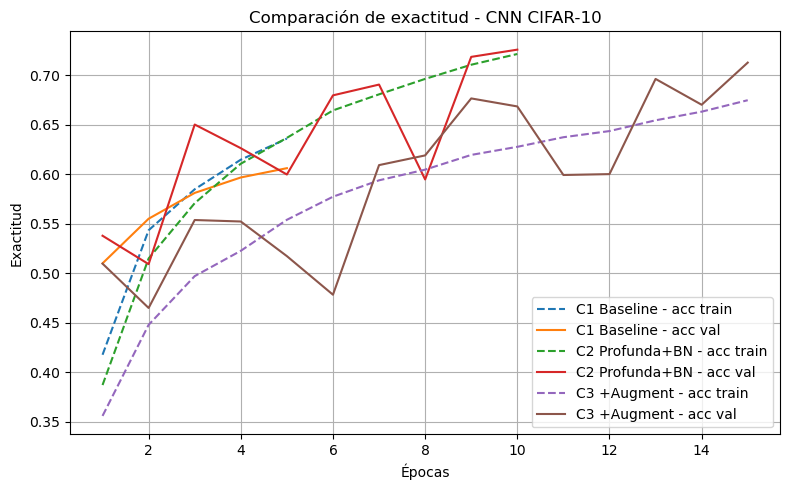

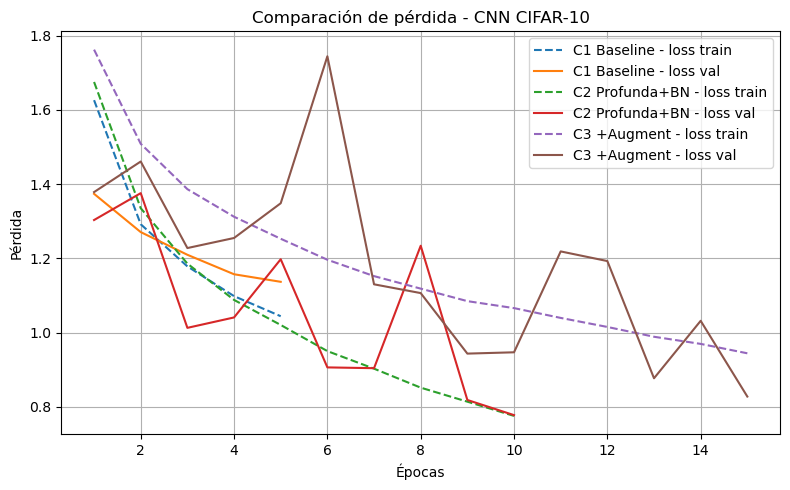

In [20]:
# Gráficas: comparación de accuracy y loss (C1 vs C2 vs C3)

def plot_accuracy_histories(histories, labels, title):
    """
    Grafica la exactitud de entrenamiento y validación
    para cada historial de entrenamiento recibido.
    """
    plt.figure(figsize=(8, 5))
    for hist, lab in zip(histories, labels):
        epochs = range(1, len(hist.history["accuracy"]) + 1)
        # Curva de exactitud en entrenamiento (línea punteada)
        plt.plot(epochs, hist.history["accuracy"],
                 linestyle="--", label=f"{lab} - acc train")
        # Curva de exactitud en validación
        plt.plot(epochs, hist.history["val_accuracy"],
                 label=f"{lab} - acc val")
    plt.xlabel("Épocas")
    plt.ylabel("Exactitud")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_loss_histories(histories, labels, title):
    """
    Grafica la pérdida de entrenamiento y validación
    para cada modelo.
    """
    plt.figure(figsize=(8, 5))
    for hist, lab in zip(histories, labels):
        epochs = range(1, len(hist.history["loss"]) + 1)
        # Curva de pérdida en entrenamiento (línea punteada)
        plt.plot(epochs, hist.history["loss"],
                 linestyle="--", label=f"{lab} - loss train")
        # Curva de pérdida en validación
        plt.plot(epochs, hist.history["val_loss"],
                 label=f"{lab} - loss val")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Historias de entrenamiento de los tres modelos
histories = [history_c1, history_c2, history_c3]
labels    = ["C1 Baseline", "C2 Profunda+BN", "C3 +Augment"]

plot_accuracy_histories(histories, labels, "Comparación de exactitud - CNN CIFAR-10")
plot_loss_histories(histories, labels, "Comparación de pérdida - CNN CIFAR-10")


## Análisis visual de ejemplos mal clasificados

A partir del conjunto de prueba se muestran **imágenes donde fallan los modelos**:
- C1: errores debido a baja capacidad del modelo
- C2: errores más específicos por confusiones entre clases similares
- C3: menor número de errores gracias al data augmentation

Esto ayuda a entender **qué clases son más conflictivas** y a evaluar la calidad de las predicciones.


C1 Baseline - mal clasificados: 3955
C2 Profunda+BN - mal clasificados: 2676
C3 +Augment - mal clasificados: 2865


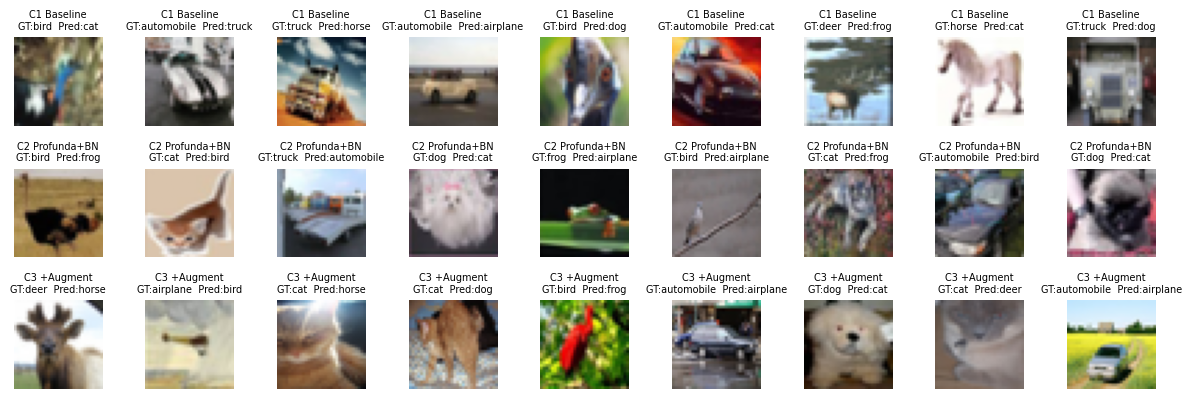

In [21]:
# Análisis de errores: C1, C2 y C3

# Nombres de clases
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Predicciones de los tres modelos
y_pred_c1 = np.argmax(cnn_c1.predict(x_test, verbose=0), axis=1)
y_pred_c2 = np.argmax(cnn_c2.predict(x_test, verbose=0), axis=1)
y_pred_c3 = np.argmax(cnn_c3.predict(x_test, verbose=0), axis=1)

preds = [y_pred_c1, y_pred_c2, y_pred_c3]
labels = ["C1 Baseline", "C2 Profunda+BN", "C3 +Augment"]

plt.figure(figsize=(12, 12))

for i, (pred, label) in enumerate(zip(preds, labels)):
    # ÍNDICES de errores para ese modelo
    misclassified_idx = np.where(pred != y_test)[0]
    print(f"{label} - mal clasificados: {len(misclassified_idx)}")

    # Selección de 9 ejemplos aleatorios
    num_examples = min(9, len(misclassified_idx))
    sample_idx = np.random.choice(misclassified_idx, num_examples, replace=False)

    # Gráficas
    for j, idx in enumerate(sample_idx):
        plt.subplot(9, 9, i * 9 + j + 1)
        plt.imshow(x_test[idx])
        true_label = class_names[y_test[idx]]
        pred_label = class_names[pred[idx]]
        plt.title(f"{label}\nGT:{true_label}  Pred:{pred_label}", fontsize=7)
        plt.axis("off")

plt.tight_layout()
plt.show()


## Matriz de confusión comparativa

Se grafican las matrices para los tres modelos.
Esto permite analizar:
- Qué clases son más fáciles de distinguir,
- Cuáles tienden a confundirse,
- Diferencias progresivas entre C1 → C2 → C3.

Es una herramienta clave para entender el rendimiento **por clase** y no solo por exactitud total.


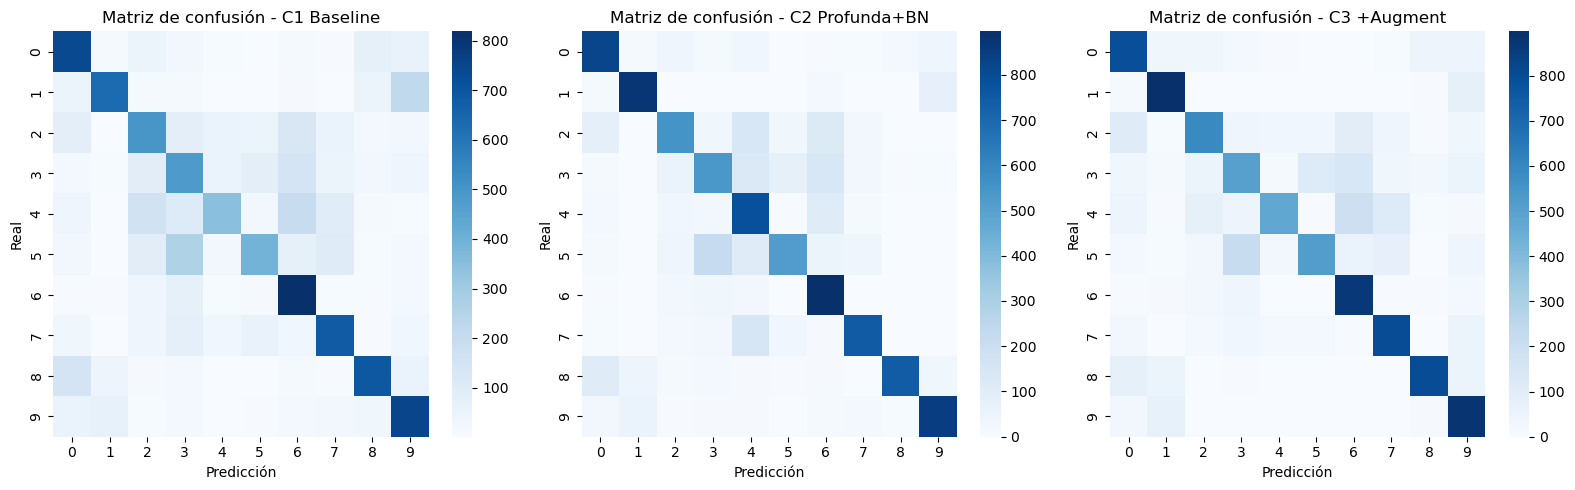

In [22]:
# Matriz de confusión: C1, C2 y C3

preds = [y_pred_c1, y_pred_c2, y_pred_c3]
titles = ["C1 Baseline", "C2 Profunda+BN", "C3 +Augment"]

plt.figure(figsize=(16, 5))

for i, (pred, title) in enumerate(zip(preds, titles)):
    cm = confusion_matrix(y_test, pred)
    plt.subplot(1, 3, i + 1)
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(f"Matriz de confusión - {title}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")

plt.tight_layout()
plt.show()


## Registro estructurado de experimentos (CSV)

Se genera una tabla resumen con la información clave de cada experimento:
- ID del modelo (C1, C2, C3),
- Número de épocas,
- Exactitud de entrenamiento, validación y prueba,
- Observaciones básicas.

Este registro permite realizar un **estudio de ablación**, mostrando el efecto de:
- Mayor profundidad de red (C2),
- Data Augmentation (C3).

El archivo `.csv` puede utilizarse como **libro de experimentos** para análisis posterior.


In [23]:
# Libro de registro en CSV 

# Se convierte la lista de registros en un DataFrame
df_log_cnn = pd.DataFrame(registro_cnn)

# Se guarda como archivo CSV para documentar los experimentos
df_log_cnn.to_csv("experimentos_cnn.csv", index=False)

# Se muestra el resumen en pantalla
df_log_cnn


,ID,Modelo,Epocas,Batch_size,Optimizador,LR,Acc_train,Acc_val,Acc_test,Loss_train,Loss_val,Loss_test,Tiempo_min,Observaciones
0,C1,C1 CNN Baseline,5,64,Adam,0.001,0.582625,0.5744,0.5686,1.177669,1.226409,1.218239,1.77,"Arquitectura simple; sirve como línea base, se..."
1,C2,C2 CNN Profunda+BN+Dropout,10,64,Adam,0.001,0.721275,0.6770,0.6818,0.778984,0.935160,0.926846,15.59,Mayor capacidad de representación; mejora en t...
2,C1,C1 CNN Baseline,5,64,Adam,0.001,0.636175,0.6063,0.6045,1.044033,1.136730,1.122707,1.79,"Arquitectura simple; sirve como línea base, se..."
3,C2,C2 CNN Profunda+BN+Dropout,10,64,Adam,0.001,0.726000,0.6756,0.6734,0.766970,0.935448,0.944674,14.63,Mayor capacidad de representación; mejora en t...
4,C2,C2 CNN Profunda+BN+Dropout,10,64,Adam,0.001,0.721700,0.7261,0.7324,0.775468,0.777564,0.784624,14.96,Mayor capacidad de representación; mejora en t...
5,C3,C3 CNN + Data Augmentation,15,64,Adam,0.001,0.675000,0.7130,0.7135,0.944158,0.827582,0.841097,27.67,El aumento de datos ayuda a la generalización ...
